In [33]:
# Import necessary libraries and make necessary arrangements
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

## TO DO:

- min max
- lasso ridge
- r2
- adjusted r2
- conclusion and inference

In [34]:
df = pd.read_excel("data/orders_by_location.xlsx")

In [35]:
df

,location_id,location_name,date,order_count
0,6.0,"San Francisco, CA",2018-01-01,8411.0
1,19.0,"Santa Barbara, CA",2018-01-01,265.0
2,6.0,"San Francisco, CA",2018-01-02,4886.0
3,19.0,"Santa Barbara, CA",2018-01-02,178.0
4,6.0,"San Francisco, CA",2018-01-03,4505.0
...,...,...,...,...
1293,6.0,"San Francisco, CA",2019-08-10,7934.0
1294,19.0,"Santa Barbara, CA",2019-08-10,263.0
1295,114.0,"Los Angeles, CA",2019-08-11,216.0
1296,6.0,"San Francisco, CA",2019-08-11,7468.0


## HELPER FUNCTIONS

In [36]:
# Check dataframe
def check_df(dataframe, head=5, tail=5, quan=False):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(tail))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

    if quan:
        print("##################### Quantiles #####################")
        print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [37]:
# # Change Datatypes of location_id and order_count to int
# def change_datatypes(df):
#     convert_dict = {'location_id': int,
#                 'order_count': int }
#     df = df.astype(convert_dict)  
#     print(df.dtypes)


In [38]:
# Date Features
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

In [39]:
# Random Noise
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [40]:
# Lag/Shifted Features
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['orders_lag_' + str(lag)] = dataframe.groupby(["location_name"])['order_count'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [41]:
# Rolling Mean Features
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['orders_roll_mean_' + str(window)] = dataframe.groupby(["location_name"])['order_count']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=14, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [42]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['orders_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["location_name"])['order_count'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

## EXPLORATORY DATA ANALYSIS

In [43]:
# Let's check the time periods of train and test sets
df["date"].min(), df["date"].max()  

(Timestamp('2018-01-01 00:00:00'), Timestamp('2019-08-11 00:00:00'))

In [44]:
check_df(df)

##################### Shape #####################
(1298, 4)
##################### Types #####################
location_id             float64
location_name            object
date             datetime64[ns]
order_count             float64
dtype: object
##################### Head #####################
   location_id      location_name       date  order_count
0          6.0  San Francisco, CA 2018-01-01       8411.0
1         19.0  Santa Barbara, CA 2018-01-01        265.0
2          6.0  San Francisco, CA 2018-01-02       4886.0
3         19.0  Santa Barbara, CA 2018-01-02        178.0
4          6.0  San Francisco, CA 2018-01-03       4505.0
##################### Tail #####################
      location_id      location_name       date  order_count
1293          6.0  San Francisco, CA 2019-08-10       7934.0
1294         19.0  Santa Barbara, CA 2019-08-10        263.0
1295        114.0    Los Angeles, CA 2019-08-11        216.0
1296          6.0  San Francisco, CA 2019-08-11       7468

In [45]:
# change_datatypes(df)

In [46]:
convert_dict = {'location_id': int,
                'order_count': int }
df = df.astype(convert_dict)  

In [47]:
df.dtypes

location_id               int32
location_name            object
date             datetime64[ns]
order_count               int32
dtype: object

In [48]:
# Checking the total number of location_ids of warehouse
values = df['location_id'].value_counts(dropna=False).keys().tolist()
counts = df['location_id'].value_counts(dropna=False).tolist()
value_dict = dict(zip(values, counts))
value_dict

{6: 588, 19: 588, 114: 122}

In [49]:
# Checking the total number of location_ids of warehouse
values = df['location_name'].value_counts(dropna=False).keys().tolist()
counts = df['location_name'].value_counts(dropna=False).tolist()
value_dict = dict(zip(values, counts))
value_dict

{'San Francisco, CA': 588, 'Santa Barbara, CA': 588, 'Los Angeles, CA': 122}

In [50]:
# There is need to clean the location data

In [51]:
# Distribution of Orders
df["order_count"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

count     1298.000000
mean      3618.233436
std       3426.050028
min          0.000000
10%        207.700000
30%        881.600000
50%       1592.500000
70%       5940.900000
80%       6995.000000
90%       8522.800000
95%       9742.200000
99%      11810.870000
max      14673.000000
Name: order_count, dtype: float64

In [52]:
# Sales distribution per location
df.groupby(["location_name"]).agg({"order_count": ["sum"]})

,order_count
,sum
location_name,
"Los Angeles, CA",10178
"San Francisco, CA",4150668
"Santa Barbara, CA",535621


In [53]:
# Sales statistics per location
df.groupby(["location_name"]).agg({"order_count": ["sum", "mean", "median", "std"]})

order_count                                  
                          sum         mean  median          std
location_name                                                  
Los Angeles, CA         10178    83.426230    80.5    43.722059
San Francisco, CA     4150668  7058.959184  6720.5  1962.626339
Santa Barbara, CA      535621   910.920068  1004.5   534.043776

## Feature Engineering

### Adding Data Features

In [54]:
########################
# Date Features
########################
df = create_date_features(df)
check_df(df)

##################### Shape #####################
(1298, 13)
##################### Types #####################
location_id                int32
location_name             object
date              datetime64[ns]
order_count                int32
month                      int64
day_of_month               int64
day_of_year                int64
week_of_year               int64
day_of_week                int64
year                       int64
is_wknd                    int64
is_month_start             int32
is_month_end               int32
dtype: object
##################### Head #####################
   location_id      location_name       date  order_count  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end
0            6  San Francisco, CA 2018-01-01         8411      1             1            1             1            0  2018        0               1             0
1           19  Santa Barbara, CA 2018-01-01          265      1     

In [55]:
df.groupby(["location_name", "month"]).agg({"order_count": ["sum", "mean", "median", "std"]})

order_count                                  
                                sum         mean  median          std
location_name     month                                              
Los Angeles, CA   4             655    34.473684    32.0    22.777592
                  5            2004    64.645161    65.0    17.230880
                  6            2668    88.933333    85.0    48.731448
                  7            3312   106.838710   110.0    25.300984
                  8            1539   139.909091   124.0    39.404199
San Francisco, CA 1          438734  7076.354839  6529.0  2059.704086
                  2          451326  8059.392857  7628.0  2299.911585
                  3          500681  8075.500000  7344.5  1964.064210
                  4          452120  7535.333333  7053.0  1968.986280
                  5          411708  6640.451613  6639.0  1719.063829
                  6          365044  6084.066667  5934.0  1362.160160
                  7          368422  5942.290323  5704.0  1414.841246
                  8          256572  6108.857143  6070.0  1268.947779
                  9          218531  7284.366667  7306.0  1682.957321
                  10         213414  6884.322581  6083.0  1669.502249
                  11         230537  7684.566667  6984.5  2086.499323
                  12         243579  7857.387097  7040.0  2054.262815
Santa Barbara, CA 1           64843  1045.854839  1038.5   442.021543
                  2           77487  1383.696429  1333.0   305.194717
                  3           69813  1126.016129  1245.0   454.074324
                  4           89529  1492.150000  1408.0   271.037731
                  5           35573   573.758065   438.0   324.658998
                  6           20901   348.350000   342.5    68.441197
                  7           23159   373.532258   337.5   140.165092
                  8           20357   484.690476   336.5   315.187168
                  9           36189  1206.300000  1117.0   282.348910
                  10          36944  1191.741935  1138.0   205.797468
                  11          32946  1098.200000  1204.5   486.707474
                  12          27880   899.354839   599.0   742.901768

In [56]:
########################
# Lag/Shifted Features
########################
# Below sort_values() is so important!
df.sort_values(by=['location_name', 'date'], axis=0, inplace=True)

In [57]:
df = lag_features(df, [14])

In [58]:
check_df(df)

##################### Shape #####################
(1298, 14)
##################### Types #####################
location_id                int32
location_name             object
date              datetime64[ns]
order_count                int32
month                      int64
day_of_month               int64
day_of_year                int64
week_of_year               int64
day_of_week                int64
year                       int64
is_wknd                    int64
is_month_start             int32
is_month_end               int32
orders_lag_14            float64
dtype: object
##################### Head #####################
     location_id    location_name       date  order_count  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  orders_lag_14
932          114  Los Angeles, CA 2019-04-12            6      4            12          102            15            4  2019        1               0             0            NaN
935   

In [59]:
df.head()

,location_id,location_name,date,order_count,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,orders_lag_14
932,114,"Los Angeles, CA",2019-04-12,6,4,12,102,15,4,2019,1,0,0,NaN
935,114,"Los Angeles, CA",2019-04-13,0,4,13,103,15,5,2019,1,0,0,NaN
938,114,"Los Angeles, CA",2019-04-14,0,4,14,104,15,6,2019,1,0,0,NaN
941,114,"Los Angeles, CA",2019-04-15,32,4,15,105,16,0,2019,0,0,0,NaN
944,114,"Los Angeles, CA",2019-04-16,11,4,16,106,16,1,2019,0,0,0,NaN


In [60]:
########################
# Rolling Mean Features
########################
df = roll_mean_features(df, [14])
df.tail()

,location_id,location_name,date,order_count,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,orders_lag_14,orders_roll_mean_14
1285,19,"Santa Barbara, CA",2019-08-07,308,8,7,219,32,2,2019,0,0,0,357.789302,315.602414
1288,19,"Santa Barbara, CA",2019-08-08,299,8,8,220,32,3,2019,0,0,0,336.940575,311.432198
1291,19,"Santa Barbara, CA",2019-08-09,175,8,9,221,32,4,2019,1,0,0,292.650083,306.422578
1294,19,"Santa Barbara, CA",2019-08-10,263,8,10,222,32,5,2019,1,0,0,460.992693,306.922986
1297,19,"Santa Barbara, CA",2019-08-11,341,8,11,223,32,6,2019,1,0,0,371.473581,302.934029


In [61]:
########################
# Exponentially Weighted Mean Features
########################
alphas = [0.95, 0.75, 0.5]
lags = [14]

df = ewm_features(df, alphas, lags)

check_df(df)

##################### Shape #####################
(1298, 18)
##################### Types #####################
location_id                             int32
location_name                          object
date                           datetime64[ns]
order_count                             int32
month                                   int64
day_of_month                            int64
day_of_year                             int64
week_of_year                            int64
day_of_week                             int64
year                                    int64
is_wknd                                 int64
is_month_start                          int32
is_month_end                            int32
orders_lag_14                         float64
orders_roll_mean_14                   float64
orders_ewm_alpha_095_lag_14           float64
orders_ewm_alpha_075_lag_14           float64
orders_ewm_alpha_05_lag_14            float64
dtype: object
##################### Head ####################

In [62]:
df.head()

,location_id,location_name,date,order_count,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,orders_lag_14,orders_roll_mean_14,orders_ewm_alpha_095_lag_14,orders_ewm_alpha_075_lag_14,orders_ewm_alpha_05_lag_14
932,114,"Los Angeles, CA",2019-04-12,6,4,12,102,15,4,2019,1,0,0,NaN,NaN,NaN,NaN,NaN
935,114,"Los Angeles, CA",2019-04-13,0,4,13,103,15,5,2019,1,0,0,NaN,NaN,NaN,NaN,NaN
938,114,"Los Angeles, CA",2019-04-14,0,4,14,104,15,6,2019,1,0,0,NaN,NaN,NaN,NaN,NaN
941,114,"Los Angeles, CA",2019-04-15,32,4,15,105,16,0,2019,0,0,0,NaN,NaN,NaN,NaN,NaN
944,114,"Los Angeles, CA",2019-04-16,11,4,16,106,16,1,2019,0,0,0,NaN,NaN,NaN,NaN,NaN


In [63]:
df = pd.get_dummies(df, columns=['location_id', 'day_of_week', 'month'])

## Train Validation Split

In [64]:
########################
# Time-Based Validation Sets
########################
# train = df.loc[(df["date"] < "2018-06-11"), :]

# # Validation set including first 3 months of 2017 (as we will forecast the first 3 months of 2018)
# val = df.loc[(df["date"] >= "2018-06-11") & (df["date"] <= "2019-08-11"), :]

In [65]:
df.shape

(1298, 37)

In [66]:
len(df)

1298

In [123]:
train = df.head(len(df)-14)
val = df.tail(14)

In [131]:
len(train)

1284

In [132]:
len(val)

14

In [125]:
cols = [col for col in df.columns if col not in ['date', 'location_name', "order_count", "year"]]

In [126]:
y = train['order_count']
X = train[cols]

In [127]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle = True,random_state=42)

In [128]:
# cols = [col for col in df.columns if col not in ['date', 'location_name', "order_count"]]

In [129]:
# # Define dependent variable and independent variables 
# Y_train = df['order_count']
# X_train = df[cols]

# Y_val = val['order_count']
# X_val = val[cols]

In [133]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((898, 33), (898,), (386, 33), (386,))

## Checking the Correlation 

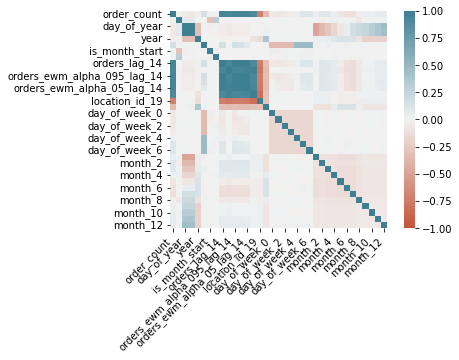

In [134]:
import seaborn as sns

corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [135]:
# train[train.columns[1:-1]].apply(lambda x: x.corr(train['order_count']))

print(train[[c for c in train.columns]]
      .corr()['order_count'].sort_values(ascending=False))

order_count                    1.000000
orders_ewm_alpha_075_lag_14    0.952787
orders_ewm_alpha_095_lag_14    0.951346
orders_lag_14                  0.950383
orders_ewm_alpha_05_lag_14     0.948985
orders_roll_mean_14            0.936052
location_id_6                  0.913474
is_wknd                        0.166378
day_of_week_5                  0.102593
day_of_week_6                  0.102216
month_2                        0.096292
month_3                        0.090313
month_11                       0.047626
month_12                       0.047597
month_1                        0.038807
month_9                        0.038186
day_of_week_4                  0.030272
month_10                       0.025218
month_4                        0.025118
is_month_end                   0.015965
is_month_start                 0.010045
day_of_month                  -0.017021
year                          -0.024798
month_8                       -0.029155
day_of_year                   -0.042143


In [136]:
train

,location_name,date,order_count,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,orders_lag_14,orders_roll_mean_14,orders_ewm_alpha_095_lag_14,orders_ewm_alpha_075_lag_14,orders_ewm_alpha_05_lag_14,location_id_6,location_id_19,location_id_114,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
932,"Los Angeles, CA",2019-04-12,6,12,102,15,2019,1,0,0,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
935,"Los Angeles, CA",2019-04-13,0,13,103,15,2019,1,0,0,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
938,"Los Angeles, CA",2019-04-14,0,14,104,15,2019,1,0,0,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
941,"Los Angeles, CA",2019-04-15,32,15,105,16,2019,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
944,"Los Angeles, CA",2019-04-16,11,16,106,16,2019,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,"Santa Barbara, CA",2019-07-24,357,24,205,30,2019,0,0,0,366.660725,476.246957,371.243309,369.191831,363.811545,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1246,"Santa Barbara, CA",2019-07-25,335,25,206,30,2019,0,0,0,405.390669,449.831061,404.262165,396.797958,384.905772,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1249,"Santa Barbara, CA",2019-07-26,292,26,207,30,2019,1,0,0,557.551507,424.698964,550.313108,517.699489,471.452886,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1252,"Santa Barbara, CA",2019-07-27,460,27,208,30,2019,1,0,0,1037.086388,403.734699,1010.765655,905.674872,753.226443,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


In [137]:
df.isnull().sum(axis = 0)

location_name                   0
date                            0
order_count                     0
day_of_month                    0
day_of_year                     0
week_of_year                    0
year                            0
is_wknd                         0
is_month_start                  0
is_month_end                    0
orders_lag_14                  42
orders_roll_mean_14            42
orders_ewm_alpha_095_lag_14    42
orders_ewm_alpha_075_lag_14    42
orders_ewm_alpha_05_lag_14     42
location_id_6                   0
location_id_19                  0
location_id_114                 0
day_of_week_0                   0
day_of_week_1                   0
day_of_week_2                   0
day_of_week_3                   0
day_of_week_4                   0
day_of_week_5                   0
day_of_week_6                   0
month_1                         0
month_2                         0
month_3                         0
month_4                         0
month_5       

### Linear Regression

In [208]:
df_regr = df.dropna()

In [209]:
df_regr.isnull().sum(axis = 0)

location_name                  0
date                           0
order_count                    0
day_of_month                   0
day_of_year                    0
week_of_year                   0
year                           0
is_wknd                        0
is_month_start                 0
is_month_end                   0
orders_lag_14                  0
orders_roll_mean_14            0
orders_ewm_alpha_095_lag_14    0
orders_ewm_alpha_075_lag_14    0
orders_ewm_alpha_05_lag_14     0
location_id_6                  0
location_id_19                 0
location_id_114                0
day_of_week_0                  0
day_of_week_1                  0
day_of_week_2                  0
day_of_week_3                  0
day_of_week_4                  0
day_of_week_5                  0
day_of_week_6                  0
month_1                        0
month_2                        0
month_3                        0
month_4                        0
month_5                        0
month_6   

In [210]:
df_regr.shape

(1256, 37)

In [222]:
regr_train = df_regr.head(len(df)-14)
regr_val = df_regr.tail(14)

In [212]:
cols = [col for col in df.columns if col not in ['date', 'location_name', "order_count", "year"]]

In [213]:
regr_y = regr_train['order_count']
regr_X = regr_train[cols]

In [220]:
regr_val_y = regr_val['order_count']
regr_val_X = regr_val[cols]

In [224]:
regr_val.shape

(14, 37)

In [225]:
from sklearn.model_selection import train_test_split
regr_X_train, regr_X_test, regr_y_train, regr_y_test = train_test_split(regr_X, regr_y, 
                                                                        test_size=0.30, shuffle = True,random_state=42)

In [226]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [227]:
space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]

In [228]:
# define search
model = Ridge()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)

In [229]:
# execute search
result = search.fit(regr_X_train, regr_y_train)

In [230]:
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -560.8487931018186
Best Hyperparameters: {'alpha': 0.01, 'fit_intercept': True, 'normalize': False, 'solver': 'sag'}


In [231]:
model = Ridge(alpha=0.001, fit_intercept=True, normalize=False, solver= 'sag')

In [232]:
result1 = model.fit(regr_X_train, regr_y_train)

In [233]:
preds = model.predict(regr_X_test)

In [234]:
r2 = r2_score(regr_y_test, preds)

In [235]:
r2

0.9338954745254124

In [236]:
# Validation 

In [237]:
final_preds = model.predict(regr_val_X)

In [238]:
r2_final = r2_score(regr_val_y, final_preds)

In [239]:
r2_final

-1.3899985737568672

In [240]:
pd.DataFrame(list(zip(regr_val_y, final_preds)))

,0,1
0,287,360.874190
1,278,294.559951
2,313,331.178410
3,258,291.115460
4,299,338.830328
5,336,320.894024
6,337,434.042199
7,269,401.620688
8,313,290.857797
9,308,296.817709


### XGBoost Regressor

In [144]:
# !pip install xgboost

In [145]:
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor

In [253]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [20, 50, 70, 100, 200, 400]}

In [254]:
xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

In [255]:
xgb_grid.fit(X_train,
         y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             n_jobs=5,
        

In [256]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.939693763075512
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'nthread': 4, 'objective': 'reg:squarederror', 'subsample': 0.7}


In [257]:
preds = xgb_grid.predict(X_test)

In [258]:
# preds

In [259]:
# Y_val

In [260]:
pd.DataFrame(list(zip(y_test, preds)))

,0,1
0,10567,10283.033203
1,127,134.714951
2,98,131.024582
3,192,117.388603
4,1769,1389.385742
...,...,...
372,218,313.925537
373,1198,1241.790649
374,374,318.241028
375,7540,5904.934082


In [261]:
from sklearn.metrics import r2_score
r2_score(y_test, preds)

0.9554287694188516

In [262]:
X_train.columns

Index(['day_of_month', 'day_of_year', 'week_of_year', 'is_wknd', 'is_month_start', 'is_month_end', 'orders_lag_14', 'orders_roll_mean_14', 'orders_ewm_alpha_095_lag_14', 'orders_ewm_alpha_075_lag_14', 'orders_ewm_alpha_05_lag_14', 'location_id_6', 'location_id_19', 'location_id_114', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

In [263]:
# Adj r2 = 1-(1-R2)*(n-1)/(n-p-1)

### Fitting final model

In [264]:
# params

In [265]:
xgb = XGBRegressor(colsample_bytree= 0.7,
 learning_rate= 0.05,
 max_depth= 6,
 min_child_weight= 4,
 n_estimators= 100,
 nthread= 4,
 objective= 'reg:squarederror',
 subsample= 0.7)

In [266]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4, nthread=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [267]:
xgb.feature_importances_

array([5.0776913e-03, 6.7603798e-03, 1.0097699e-02, 7.8465432e-02,
       4.2866796e-04, 6.4576776e-03, 5.0382006e-01, 1.3759963e-01,
       1.0580702e-01, 3.4491859e-02, 1.3677030e-02, 0.0000000e+00,
       1.9631110e-04, 0.0000000e+00, 1.0023468e-02, 7.8166807e-03,
       6.6717798e-03, 5.5747749e-03, 4.3419562e-03, 1.1735610e-02,
       2.1311552e-03, 4.9861339e-03, 5.8508036e-03, 2.5310365e-03,
       3.2026221e-03, 6.6630789e-03, 4.5533042e-04, 5.0868099e-03,
       0.0000000e+00, 7.6036179e-03, 7.5166812e-03, 4.3380456e-03,
       5.9096777e-04], dtype=float32)

<BarContainer object of 33 artists>

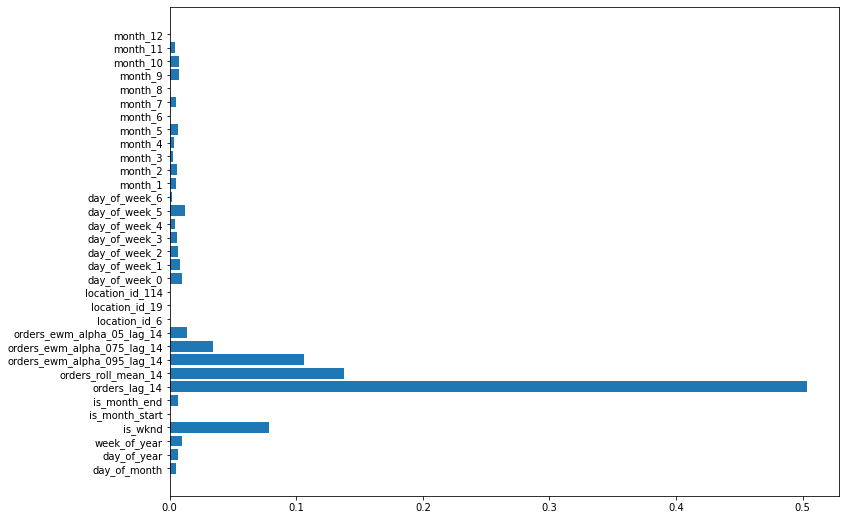

In [276]:
plt.figure(figsize=(12, 9))
plt.barh(X_train.columns, xgb.feature_importances_)

In [269]:
xgb.predict(X_test)

array([10245.756   ,   132.71541 ,   135.5059  ,   113.82532 ,
        1396.7733  ,  6402.197   ,  1332.3712  ,  6351.266   ,
         350.09583 ,   566.15295 ,  8997.76    ,  1090.029   ,
        7294.199   ,   324.46808 ,  1339.6454  ,  5727.023   ,
        1213.4121  ,  7750.049   ,  8862.371   ,  1436.1743  ,
        1495.9934  ,  8610.525   ,  7947.2695  ,  1395.6028  ,
        1245.6525  ,  1470.7137  ,  1165.1064  ,  5875.1523  ,
        9153.649   ,   103.998795,  1016.4802  ,  4991.337   ,
         299.24588 ,  7038.087   ,   358.07208 ,  9535.701   ,
        5720.7754  ,  5513.789   ,  1099.343   ,  7546.8184  ,
         341.54953 ,   314.89697 ,  1432.0947  ,  5663.0894  ,
         435.4843  ,  1410.8088  ,  4224.9863  ,   103.50123 ,
        1396.9148  ,  1306.3147  ,   372.70892 ,  6584.4565  ,
        6647.746   ,   392.37448 ,  6242.736   ,  4992.0796  ,
        5403.963   ,  6596.0815  ,   442.37848 ,  5964.9575  ,
        7300.4644  ,  4476.1523  ,  8831.512   ,   124.

In [270]:
pd.DataFrame(list(zip(y_test, preds)))

,0,1
0,10567,10283.033203
1,127,134.714951
2,98,131.024582
3,192,117.388603
4,1769,1389.385742
...,...,...
372,218,313.925537
373,1198,1241.790649
374,374,318.241028
375,7540,5904.934082


In [271]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, preds)
r2

0.9554287694188516

In [272]:
val_X

,day_of_month,day_of_year,week_of_year,is_wknd,is_month_start,is_month_end,orders_lag_14,orders_roll_mean_14,orders_ewm_alpha_095_lag_14,orders_ewm_alpha_075_lag_14,orders_ewm_alpha_05_lag_14,location_id_6,location_id_19,location_id_114,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
583,19,292,42,1,0,0,881.618746,1199.016925,890.004368,931.037652,1006.564445,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
585,20,293,42,1,0,0,1121.946292,1222.087519,1111.350218,1075.009413,1064.782223,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
587,21,294,42,1,0,0,1282.067929,1235.598025,1274.417511,1231.002353,1173.891111,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
589,22,295,43,0,0,0,1113.766299,1234.993504,1118.220876,1140.250588,1141.945556,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
591,23,296,43,0,0,0,1133.584848,1228.206084,1134.161044,1136.312647,1138.472778,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1285,7,219,32,0,0,0,357.789302,315.602414,354.920712,355.167895,370.341419,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1288,8,220,32,0,0,0,336.940575,311.432198,335.996036,340.041974,352.670710,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1291,9,221,32,1,0,0,292.650083,306.422578,294.199802,304.010493,322.335355,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1294,10,222,32,1,0,0,460.992693,306.922986,451.709990,421.002623,391.167677,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [273]:
final_preds = xgb.predict(val_X)

In [274]:
r2_score(val_y, final_preds)

0.874633121878262

In [275]:
pd.DataFrame(list(zip(val_y, final_preds)))

,0,1
0,1026,1147.458374
1,1149,1236.686646
2,1537,1413.779053
3,989,1095.079956
4,949,1117.477905
...,...,...
292,308,314.896973
293,299,282.852631
294,175,279.937561
295,263,320.007233
